In [1]:
import xarray as xr
import dask
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import random_split
import torch
import os
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import shapely.geometry as sgeom

In [2]:
data_path = r"lustre_scratch/data/sst_gradients/" # dir where data is stored
plot_path = "plots/" # dir to store plots 
year_list = ['2017'] # years to take data from, 2017-2020
## lcate files and load into single dataset 
file_list = []
for year in year_list: 
    folder_path = os.path.join(data_path, year)
    if os.path.isdir(folder_path):
        for file in os.listdir(folder_path): 
            file_path = os.path.join(folder_path, file)
            if file_path.endswith('.nc'): 
                file_list.append(file_path)
    else:
        raise Exception(f'The year {year} is not in the dataset.')
ds = xr.open_mfdataset(file_list, combine = 'nested', concat_dim = 'i', parallel=True)
N_data = len(ds.gRsst)
N_pixels = len(ds.gRsst[0].x)
gRsst = ds.gRsst
sstL4 = ds.sstL4

### Check Temperature Values
Ensure temperatures are within a physical range (270-310K) i.e. no outliers emerged from data analysis. Find max, min, mean and plot in histogram. 

In [ ]:
## check temperature values are normal
mean_array = ds.gRsst.mean(dim={'x','y'})
min_array = ds.gRsst.min(dim={'x','y'})
max_array = ds.gRsst.max(dim={'x','y'})
fig, ax = plt.subplots(1,3)
ax[0].hist(min_array)
ax[0].set_title('Min')
ax[0].set_ylabel('Counts')
ax[1].hist(max_array)
ax[1].set_title('Max')
ax[1].set_xlabel('Temperature (K)')
ax[2].hist(mean_array)
ax[2].set_title('Mean')
plt.tight_layout()
fig.savefig(plot_path + 'Temperature_dist')
plt.show()

### Correlation in absolute field

In [ ]:
fig, ax = plt.subplots(1,2)
randint = np.random.randint(len(ds.gRsst))
ax[0].imshow(ds.sstL4[randint].data)
ax[0].set_title('L4')
ax[0].set_xlabel('Image Pixels')
im = ax[1].imshow(ds.gRsst[randint].data)
ax[1].set_title('Gradient Restored L4')
cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax, label = 'Temperature, K')
fig.suptitle(r'1 pixel = 0.05$^o$ $\approx$ 5km', y = 0.9)
plt.savefig(plot_path + 'absolute_field')

In [ ]:
absolute_corr = xr.corr(gRsst, sstL4, dim={'x','y'})
absolute_corr.attrs['units'] = 'PPCC'
plt.hist(absolute_corr.data, bins = 50)
plt.xlabel('Correlation coeff')
plt.ylabel('Counts')
plt.title(f'Correlation between gRsst and sstL4 absolute field, mean = {np.round(absolute_corr.mean().data,3)}')
plt.savefig(plot_path + 'absolute_correlation')
plt.show()

### Correlation in gradient vector field

In [ ]:
## plot gradient 
gRsst_x_grad = gRsst.differentiate('x').data
gRsst_y_grad = gRsst.differentiate('y').data
sstL4_x_grad = sstL4.differentiate('x').data
sstL4_y_grad = sstL4.differentiate('y').data
x, y = np.meshgrid(np.arange(0,48,1),np.arange(0,48,1))
fig, ax = plt.subplots(1,2, figsize=(10,10))
i=np.random.randint(N_data)
ax[0].quiver(x, y, sstL4_x_grad[i], sstL4_y_grad[i], color='blue')
ax[0].imshow(sstL4[i].data, cmap='gray')
ax[0].set_title('sstL4')
ax[1].quiver(x, y, gRsst_x_grad[i], gRsst_y_grad[i],  color='red')
ax[1].imshow(gRsst[i].data, cmap='gray')
ax[1].set_title('grSST')
plt.savefig(plot_path + 'Gradient_field_correlation')
plt.show()

In [3]:
gRsst_grad = xr.Dataset({
    "x_grad": gRsst.differentiate('x'),
    "y_grad": gRsst.differentiate('y')})
sstL4_grad = xr.Dataset({
    "x_grad": sstL4.differentiate('x'),
    "y_grad": sstL4.differentiate('y')})

In [6]:
x_grad_corr = xr.corr(gRsst_grad.x_grad, sstL4_grad.x_grad, dim={'x','y'})
y_grad_corr = xr.corr(gRsst_grad.y_grad, sstL4_grad.y_grad, dim={'x','y'})
mean_x = x_grad_corr.mean()
mean_y = y_grad_corr.mean()
i=np.random.randint(N_data)

fig, ax = plt.subplots(1,2)
ax[0].hist(x_grad_corr.data, bins = 30) 
ax[0].set_xlabel('Correlation coeff')
ax[0].set_ylabel('Counts')
ax[0].set_title(f'x, mean = {np.round(mean_x.data,3)}')
ax[1].hist(y_grad_corr.data, bins = 30)
ax[1].set_xlabel('Correlation coeff')
ax[1].set_title(f'y, mean = {np.round(mean_y.data,3)}')
fig.suptitle('Correlation between gRsst and sstL4 gradient field')
plt.savefig(plot_path + 'gradient_correlation_hist')
plt.show()

KeyboardInterrupt: 

### Correlation in Gradient Magnitude

TypeError: Invalid shape (48,) for image data

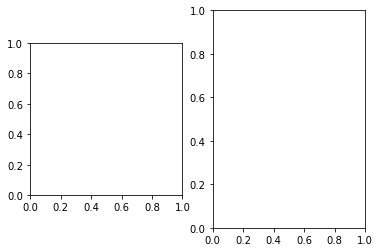

In [15]:
# NOT WORKING
sstL4_grad_mag = (sstL4_grad.x**2 + sstL4_grad.y**2)**(1/2)
gRsst_grad_mag = (gRsst_grad.x**2 + gRsst_grad.y**2)**(1/2)
fig, ax = plt.subplots(1,2)
randint = np.random.randint(len(ds.gRsst))

ax[0].imshow(sstL4_grad_mag[randint])
ax[0].set_title('L4')
ax[0].set_xlabel('Image Pixels')
im = ax[1].imshow(gRsst_grad_mag[randint])
ax[1].set_title('Gradient Restored L4')
cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax, label = 'Temperature, K')
fig.suptitle(r'1 pixel = 0.05$^o$ $\approx$ 5km', y = 0.9)
plt.savefig(plot_path + 'gradient_magnitude')

# add corr

~~~Data Spatial Distribution

In [ ]:
ds_c = xr.Dataset({"y": ds.centre.sel(s=0),
                "x": ds.centre.sel(s=1)})

x_min = int(ds_c.x.min())
x_max = int(ds_c.x.max())
y_min = int(ds_c.y.min())
y_max = int(ds_c.y.max())

fig = plt.figure(figsize=(12,24))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([x_min, x_max, y_min, y_max], crs=ccrs.PlateCarree())

#ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)

colour = "#00FF0010"

# record the number of scenes that fall into each (y,x) box
counts = {}

# track the maximum number of scenes in any bin
max_count = 0

# define the bin size in m
sz=1

n = ds_c.x.shape[0]
for i in range(0,n):
    eastings = ds_c.x
    northings = ds_c.y

    # for each scene bin the x,y coordinates
    grid_x_min = round(float(ds_c.x[i]+sz/2)/sz)*sz
    grid_y_min = round(float(ds_c.y[i]+sz/2)/sz)*sz
    
    # update the count for this bin
    if (grid_y_min,grid_x_min) not in counts:
        counts[(grid_y_min,grid_x_min)] = 0
    count = counts[(grid_y_min, grid_x_min)] + 1
    if count > max_count:
        max_count = count
    counts[(grid_y_min,grid_x_min)] = count

# for each bin, plot a rectangle on the map
for (y,x) in counts:
    count = counts[(y,x)]
    # define a red colour with transparency (alpha channel) based on the count
    col = "#FF0000%02X"%(int(1+254*((np.log(count)/np.log(float(max_count))))))
    polygon = sgeom.Polygon(shell=[(x-sz/2,y-sz/2),(x-sz/2,y+sz/2),(x+sz/2,y+sz/2),(x+sz/2,y-sz/2)])
    ax.add_geometries([polygon], ccrs.PlateCarree(),facecolor=col)
plt.savefig(plot_path + "spatial_distribution.png")
plt.show()
print('done')

### Data Temporal Distribution

In [ ]:
ds.time.plot.hist(bins=35, color = 'gray')
plt.ylabel('Counts')
plt.title('Temporal Distribution of Dataset')
plt.savefig(plot_path + 'temporal_dist')
plt.show()